In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *
from utils import specificity
from utils import sensitivity

Using TensorFlow backend.


In [3]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "7"
sess = tf.Session(config=config)
set_session(sess)

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 921
Number of healthy controls: 464
Number of AD patients: 457


In [10]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
# images are already masked
mask = None

# Model

In [12]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

In [13]:
files_train = np.array(files_train)

In [14]:
names_train = [item[53:53+10].decode('utf-8') for item in files_train]

### Normalize min-max

In [15]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel and split data

In [16]:
GSS = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

mean = np.mean(X_train[train_idx], axis=0)
std = np.std(X_train[train_idx], axis=0)
X_train = (X_train - mean) / (std)

# Training

Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 38s 50ms/step - loss: 2.0736 - acc: 0.5046 - val_loss: 1.7817 - val_acc: 0.4938
Epoch 2/45
759/759 [==============================] - 35s 46ms/step - loss: 1.5845 - acc: 0.5665 - val_loss: 1.3903 - val_acc: 0.7099
Epoch 3/45
759/759 [==============================] - 30s 40ms/step - loss: 1.3493 - acc: 0.5916 - val_loss: 1.1980 - val_acc: 0.5741
Epoch 4/45
759/759 [==============================] - 36s 47ms/step - loss: 1.1140 - acc: 0.6390 - val_loss: 1.0406 - val_acc: 0.6296
Epoch 5/45
759/759 [==============================] - 30s 40ms/step - loss: 0.9117 - acc: 0.7101 - val_loss: 0.8987 - val_acc: 0.7346
Epoch 6/45
759/759 [==============================] - 36s 48ms/step - loss: 0.7410 - acc: 0.7813 - val_loss: 0.8923 - val_acc: 0.6235
Epoch 7/45
759/759 [==============================] - 31s 40ms/step - loss: 0.6513 - acc: 0.8076 - val_loss: 0.6917 - val_acc: 0.7716
Epoch 8/45
759/7

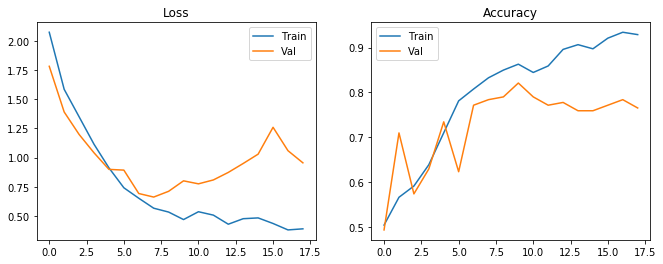

Final epoch results:
Balanced Accuracy: 76.68
Sensitivity: 87.50
Specificity: 65.85
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 31s 41ms/step - loss: 2.0357 - acc: 0.4941 - val_loss: 1.6860 - val_acc: 0.5988
Epoch 2/45
759/759 [==============================] - 35s 46ms/step - loss: 1.6538 - acc: 0.5310 - val_loss: 1.4438 - val_acc: 0.5432
Epoch 3/45
759/759 [==============================] - 35s 46ms/step - loss: 1.3117 - acc: 0.5863 - val_loss: 1.1169 - val_acc: 0.6790
Epoch 4/45
759/759 [==============================] - 35s 46ms/step - loss: 1.0136 - acc: 0.7167 - val_loss: 0.8614 - val_acc: 0.7840
Epoch 5/45
759/759 [==============================] - 35s 46ms/step - loss: 0.9385 - acc: 0.7325 - val_loss: 0.8763 - val_acc: 0.7222
Epoch 6/45
759/759 [==============================] - 35s 46ms/step - loss: 0.7998 - acc: 0.7602 - val_loss: 0.7232 - val_acc: 0.7963
Epoch 7/45
759/759 [==============================] - 35s 46ms/ste

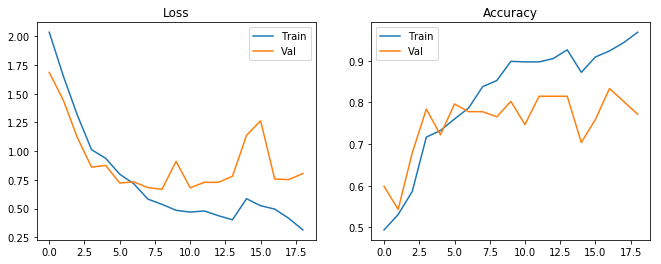

Final epoch results:
Balanced Accuracy: 77.09
Sensitivity: 71.25
Specificity: 82.93
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 36s 48ms/step - loss: 2.0661 - acc: 0.5257 - val_loss: 1.7276 - val_acc: 0.4938
Epoch 2/45
759/759 [==============================] - 37s 48ms/step - loss: 1.6228 - acc: 0.5982 - val_loss: 1.4406 - val_acc: 0.6235
Epoch 3/45
759/759 [==============================] - 36s 47ms/step - loss: 1.3835 - acc: 0.6258 - val_loss: 1.1901 - val_acc: 0.6543
Epoch 4/45
759/759 [==============================] - 36s 47ms/step - loss: 1.1411 - acc: 0.6627 - val_loss: 0.9303 - val_acc: 0.7901
Epoch 5/45
759/759 [==============================] - 35s 46ms/step - loss: 0.9123 - acc: 0.7523 - val_loss: 0.8623 - val_acc: 0.7346
Epoch 6/45
759/759 [==============================] - 36s 47ms/step - loss: 0.7756 - acc: 0.7787 - val_loss: 0.8115 - val_acc: 0.7469
Epoch 7/45
759/759 [==============================] - 36s 48ms/ste

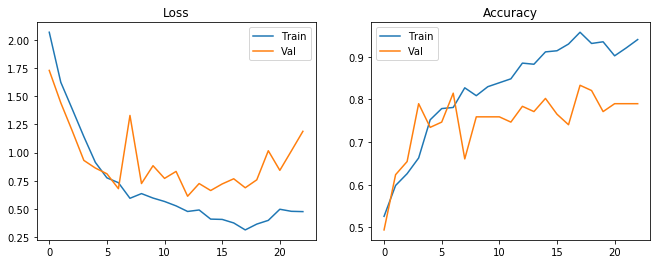

Final epoch results:
Balanced Accuracy: 78.93
Sensitivity: 72.50
Specificity: 85.37
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 36s 48ms/step - loss: 2.0624 - acc: 0.5362 - val_loss: 1.6617 - val_acc: 0.7160
Epoch 2/45
759/759 [==============================] - 36s 48ms/step - loss: 1.5863 - acc: 0.5916 - val_loss: 1.3174 - val_acc: 0.7654
Epoch 3/45
759/759 [==============================] - 36s 48ms/step - loss: 1.2299 - acc: 0.6311 - val_loss: 1.1671 - val_acc: 0.6481
Epoch 4/45
759/759 [==============================] - 36s 48ms/step - loss: 1.0676 - acc: 0.6719 - val_loss: 0.9401 - val_acc: 0.7160
Epoch 5/45
759/759 [==============================] - 36s 47ms/step - loss: 0.9045 - acc: 0.7470 - val_loss: 0.8847 - val_acc: 0.7099
Epoch 6/45
759/759 [==============================] - 36s 48ms/step - loss: 0.8153 - acc: 0.7536 - val_loss: 0.9119 - val_acc: 0.7222
Epoch 7/45
759/759 [==============================] - 36s 47ms/ste

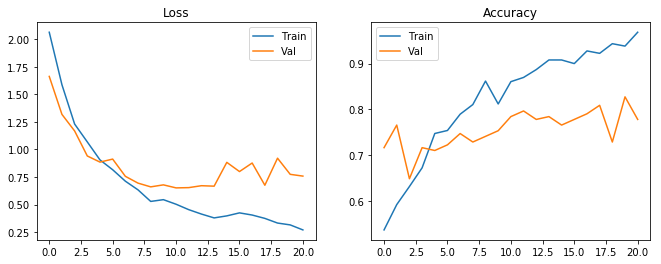

Final epoch results:
Balanced Accuracy: 77.76
Sensitivity: 76.25
Specificity: 79.27
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 36s 48ms/step - loss: 2.0094 - acc: 0.5099 - val_loss: 1.6742 - val_acc: 0.4938
Epoch 2/45
759/759 [==============================] - 36s 47ms/step - loss: 1.6017 - acc: 0.5362 - val_loss: 1.3954 - val_acc: 0.6111
Epoch 3/45
759/759 [==============================] - 36s 48ms/step - loss: 1.2871 - acc: 0.6337 - val_loss: 1.0625 - val_acc: 0.7716
Epoch 4/45
759/759 [==============================] - 36s 47ms/step - loss: 1.0352 - acc: 0.7167 - val_loss: 0.8983 - val_acc: 0.7531
Epoch 5/45
759/759 [==============================] - 35s 46ms/step - loss: 0.8714 - acc: 0.7510 - val_loss: 0.9128 - val_acc: 0.6790
Epoch 6/45
759/759 [==============================] - 35s 47ms/step - loss: 0.8348 - acc: 0.7734 - val_loss: 0.8638 - val_acc: 0.7222
Epoch 7/45
759/759 [==============================] - 35s 46ms/ste

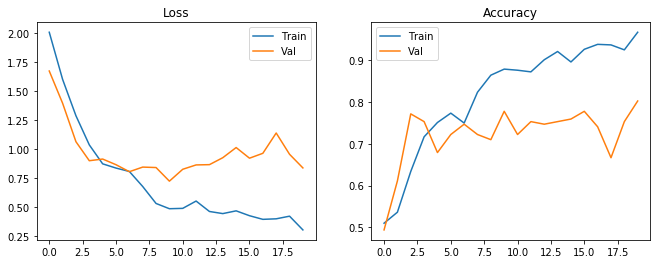

Final epoch results:
Balanced Accuracy: 80.23
Sensitivity: 78.75
Specificity: 81.71
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 35s 47ms/step - loss: 1.9490 - acc: 0.5178 - val_loss: 1.5800 - val_acc: 0.7222
Epoch 2/45
759/759 [==============================] - 35s 46ms/step - loss: 1.5538 - acc: 0.5679 - val_loss: 1.2808 - val_acc: 0.6420
Epoch 3/45
759/759 [==============================] - 35s 46ms/step - loss: 1.3339 - acc: 0.6074 - val_loss: 1.0659 - val_acc: 0.6790
Epoch 4/45
759/759 [==============================] - 35s 46ms/step - loss: 1.0126 - acc: 0.7022 - val_loss: 0.8944 - val_acc: 0.7593
Epoch 5/45
759/759 [==============================] - 35s 46ms/step - loss: 0.8388 - acc: 0.7391 - val_loss: 1.0064 - val_acc: 0.5247
Epoch 6/45
759/759 [==============================] - 35s 46ms/step - loss: 0.7444 - acc: 0.7589 - val_loss: 0.7344 - val_acc: 0.7469
Epoch 7/45
759/759 [==============================] - 35s 46ms/ste

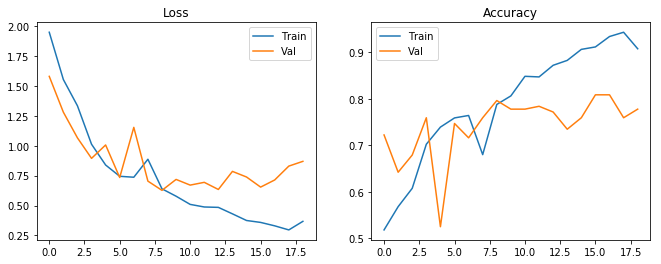

Final epoch results:
Balanced Accuracy: 77.85
Sensitivity: 83.75
Specificity: 71.95
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 36s 48ms/step - loss: 2.0807 - acc: 0.5178 - val_loss: 1.8584 - val_acc: 0.5062
Epoch 2/45
759/759 [==============================] - 35s 46ms/step - loss: 1.7157 - acc: 0.5626 - val_loss: 1.4407 - val_acc: 0.5864
Epoch 3/45
759/759 [==============================] - 35s 46ms/step - loss: 1.3738 - acc: 0.5692 - val_loss: 1.2741 - val_acc: 0.7346
Epoch 4/45
759/759 [==============================] - 35s 47ms/step - loss: 1.1189 - acc: 0.6535 - val_loss: 1.0430 - val_acc: 0.6111
Epoch 5/45
759/759 [==============================] - 36s 47ms/step - loss: 0.8940 - acc: 0.7563 - val_loss: 0.8724 - val_acc: 0.7531
Epoch 6/45
759/759 [==============================] - 36s 47ms/step - loss: 0.8102 - acc: 0.7787 - val_loss: 0.8029 - val_acc: 0.7593
Epoch 7/45
759/759 [==============================] - 36s 47ms/ste

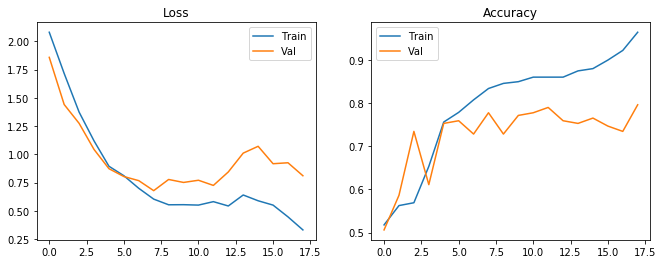

Final epoch results:
Balanced Accuracy: 79.63
Sensitivity: 80.00
Specificity: 79.27
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 40s 52ms/step - loss: 2.0111 - acc: 0.5217 - val_loss: 1.7416 - val_acc: 0.5062
Epoch 2/45
759/759 [==============================] - 37s 49ms/step - loss: 1.6006 - acc: 0.5837 - val_loss: 1.4598 - val_acc: 0.5370
Epoch 3/45
759/759 [==============================] - 38s 49ms/step - loss: 1.3175 - acc: 0.6430 - val_loss: 1.1305 - val_acc: 0.7963
Epoch 4/45
759/759 [==============================] - 38s 50ms/step - loss: 1.0439 - acc: 0.7404 - val_loss: 0.9648 - val_acc: 0.7593
Epoch 5/45
759/759 [==============================] - 37s 49ms/step - loss: 0.9033 - acc: 0.7852 - val_loss: 0.9031 - val_acc: 0.7160
Epoch 6/45
759/759 [==============================] - 37s 49ms/step - loss: 0.7200 - acc: 0.8142 - val_loss: 0.7697 - val_acc: 0.7778
Epoch 7/45
759/759 [==============================] - 37s 49ms/ste

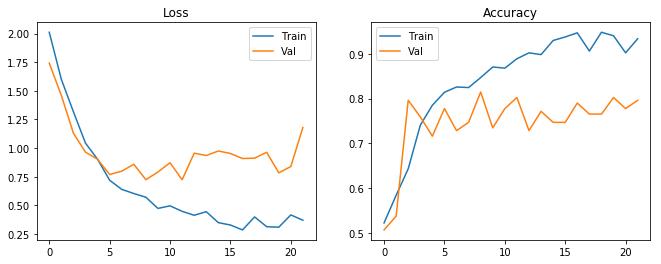

Final epoch results:
Balanced Accuracy: 79.60
Sensitivity: 77.50
Specificity: 81.71
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 39s 51ms/step - loss: 2.0392 - acc: 0.4743 - val_loss: 1.7406 - val_acc: 0.5309
Epoch 2/45
759/759 [==============================] - 37s 49ms/step - loss: 1.6213 - acc: 0.5455 - val_loss: 1.3424 - val_acc: 0.6790
Epoch 3/45
759/759 [==============================] - 37s 49ms/step - loss: 1.3024 - acc: 0.6548 - val_loss: 1.1518 - val_acc: 0.6852
Epoch 4/45
759/759 [==============================] - 37s 49ms/step - loss: 1.1382 - acc: 0.6482 - val_loss: 0.9955 - val_acc: 0.7346
Epoch 5/45
759/759 [==============================] - 37s 49ms/step - loss: 0.9033 - acc: 0.7391 - val_loss: 0.8022 - val_acc: 0.7901
Epoch 6/45
759/759 [==============================] - 37s 48ms/step - loss: 0.7368 - acc: 0.7800 - val_loss: 0.7413 - val_acc: 0.7840
Epoch 7/45
759/759 [==============================] - 37s 48ms/ste

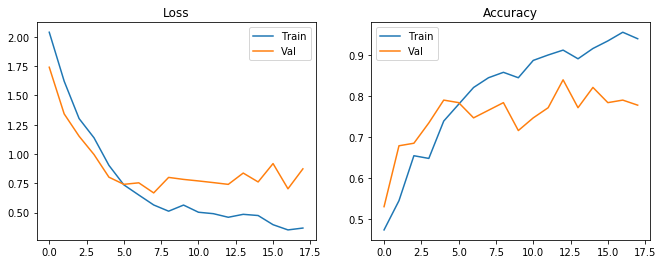

Final epoch results:
Balanced Accuracy: 77.80
Sensitivity: 80.00
Specificity: 75.61
Train on 759 samples, validate on 162 samples
Epoch 1/45
759/759 [==============================] - 35s 47ms/step - loss: 1.9708 - acc: 0.5283 - val_loss: 1.7946 - val_acc: 0.4938
Epoch 2/45
759/759 [==============================] - 35s 46ms/step - loss: 1.6281 - acc: 0.5929 - val_loss: 1.3466 - val_acc: 0.6667
Epoch 3/45
759/759 [==============================] - 35s 46ms/step - loss: 1.2804 - acc: 0.6535 - val_loss: 1.0571 - val_acc: 0.7593
Epoch 4/45
759/759 [==============================] - 35s 46ms/step - loss: 1.0248 - acc: 0.7589 - val_loss: 0.9091 - val_acc: 0.7531
Epoch 5/45
759/759 [==============================] - 35s 46ms/step - loss: 0.8252 - acc: 0.7839 - val_loss: 0.8447 - val_acc: 0.6975
Epoch 6/45
759/759 [==============================] - 35s 46ms/step - loss: 0.7564 - acc: 0.8155 - val_loss: 0.8051 - val_acc: 0.8086
Epoch 7/45
759/759 [==============================] - 35s 46ms/ste

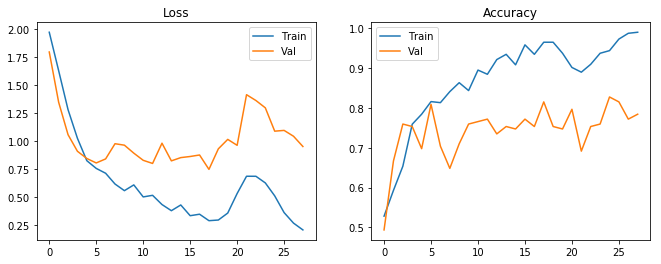

Final epoch results:
Balanced Accuracy: 78.40
Sensitivity: 78.75
Specificity: 78.05


In [17]:
# training args
lr = 0.001
lr_decay = 0.

num_trials = 10
patience = 10
store_models = False

best_epoch_acc = []
final_epoch_sens = []
final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_trial_{}.h5".format(i)), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_train[val_idx],y_train[val_idx]),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()
    
    # Evaluation
    y_pred = model.predict(X_train[val_idx], batch_size=1).flatten() # predict and turn into 1-dimensional array
    y_pred = y_pred >= 0.5 # turn predictions into binary format
    sens = sensitivity(y_train[val_idx], y_pred)
    spec = specificity(y_train[val_idx], y_pred)
    
    print("Final epoch results:")
    print("Balanced Accuracy: {:.2f}".format(((sens + spec) * 100) / 2))
    print("Sensitivity: {:.2f}".format(sens * 100))
    print("Specificity: {:.2f}".format(spec * 100))
    
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])
    final_epoch_sens.append(sens)
    final_epoch_spec.append(spec)

In [18]:
print("All best val accuracies: {}".format(best_epoch_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_epoch_acc), np.std(best_epoch_acc)))

All best val accuracies: [0.8209876543209876, 0.8333333333333334, 0.8333333333333334, 0.8271604938271605, 0.8024691358024691, 0.808641975308642, 0.7962962962962963, 0.8148148148148148, 0.8395061728395061, 0.8271604938271605]
Average best validation accuracy over 10 trials: 0.82037 (std: 0.01365)


In [19]:
print("Final epochs sensitivity: {}".format(final_epoch_sens))
print("Final epochs specificity: {}".format(final_epoch_spec))

Final epochs sensitivity: [0.875, 0.7125, 0.725, 0.7625, 0.7875, 0.8375, 0.8, 0.775, 0.8, 0.7875]
Final epochs specificity: [0.6585365853658537, 0.8292682926829268, 0.8536585365853658, 0.7926829268292683, 0.8170731707317073, 0.7195121951219512, 0.7926829268292683, 0.8170731707317073, 0.7560975609756098, 0.7804878048780488]


In [20]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

Training Time: 2.0h:5.0m:55.587817430496216s


In [21]:
np.max(history.history["val_acc"])

0.8271604938271605

In [22]:
quit()